Dneska se podíváme na hluboké zpětnovazební učení a zkusíme si implementovat hluboké Q-učení a jako cvičení si uděláme jednoduchého actor-critic agenta. 

# Hluboké Q-učení

Implementace agenta pro hluboké Q-učení je celkem přímočará - musíme mu definovat model neurnovné sítě, který bude předpovídat hodnoty funkce Q. Potom si stačí pamatovat zkušenosti agenta v replay bufferu a na základě nich po každé akci vybrat několik minibatchů, na jejichž základě upravíme váhy sítě. Zde používáme běžné trénování neuronové sítě pomocí metody fit. Musíme si jen spočítat správně cílovou hodnotu.

In [120]:
# loosely based on https://keon.io/deep-q-learning/

import random

import tensorflow as tf
import numpy as np
import gym

class DQNAgent:
    
    def __init__(self, num_inputs, num_outputs, batch_size = 32, num_batches = 16):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.eps = 1.0
        self.eps_decay = 0.995
        self.gamma = 0.95
        self.exp_buffer = []
        self.build_model()
    
    # vytvari model Q-site
    def build_model(self):
        self.model = tf.keras.models.Sequential([tf.keras.layers.Dense(24, activation=tf.nn.relu, input_dim=self.num_inputs, name='dense_1'),
                                                 tf.keras.layers.Dense(24, activation=tf.nn.relu),
                                                 tf.keras.layers.Dense(self.num_outputs, activation='linear')])
        opt = tf.keras.optimizers.Adam(lr=0.001)
        self.model.compile(optimizer=opt, loss='mse')
    
    # vraci akci agenta - pokud trenujeme tak epsilon-greedy, jinak nejlepsi podle site
    def action(self, state, train=False):
        if train and np.random.uniform() < self.eps:
            return np.random.randint(self.num_outputs)
        else: 
            return np.argmax(self.model.predict(state)[0])
        
    # ulozeni informaci do experience bufferu
    def record_experience(self, exp):
        self.exp_buffer.append(exp)
        if len(self.exp_buffer) > 2000:
            self.exp_buffer = self.exp_buffer[-2000:]
    
    # trenovani z bufferu
    def train(self):
        if (len(self.exp_buffer) <= self.batch_size):
            return
        
        for _ in range(self.num_batches):
            batch = random.sample(self.exp_buffer, self.batch_size)
            states = np.array([s for (s, _, _, _, _) in batch])
            next_states = np.array([ns for (_, _, _, ns, _) in batch])
            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))
            pred = self.model.predict(states)
            next_pred = self.model.predict(next_states)
            # spocitame cilove hodnoty
            for i, (s, a, r, ns, d) in enumerate(batch):
                pred[i][a] = r
                if not d:
                    pred[i][a] = r + self.gamma*np.amax(next_pred[i])

            self.model.fit(states, pred, epochs=1, verbose=0)
        # snizime epsilon pro epsilon-greedy strategii
        if self.eps > 0.01:
            self.eps = self.eps*self.eps_decay

# vytvorime agenta (4 vstupy, 2 akce)
agent = DQNAgent(4, 2)

env = gym.make("CartPole-v1")
print(env.action_space)

# spustime trenovani na 1000 epizodach prostredi
rewards = []
for i in range(1000):
    obs = env.reset()
    obs = np.reshape(obs, newshape=(1, -1))
    done = False
    R = 0
    t = 0
    while not done:
        old_state = obs
        action = agent.action(obs, train=True)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        r = r if not done else 10
        obs = np.reshape(obs, newshape=(1, -1))
        agent.record_experience((old_state, action, r, obs, done))
    agent.train()
    
    rewards.append(R)
    print(i, R)


Discrete(2)
0 36.0
1 44.0
2 29.0
3 11.0
4 33.0
5 23.0
6 11.0
7 14.0
8 21.0
9 25.0
10 23.0
11 15.0
12 14.0
13 20.0
14 11.0
15 27.0
16 32.0
17 19.0
18 13.0
19 22.0
20 30.0
21 11.0
22 16.0
23 17.0
24 15.0
25 22.0
26 15.0
27 12.0
28 16.0
29 16.0
30 14.0
31 15.0
32 9.0
33 15.0
34 16.0
35 13.0
36 18.0
37 11.0
38 20.0
39 15.0
40 22.0
41 12.0
42 18.0
43 13.0
44 10.0
45 11.0
46 18.0
47 37.0
48 16.0
49 19.0
50 11.0
51 25.0
52 17.0
53 20.0
54 23.0
55 20.0
56 20.0
57 42.0
58 17.0
59 26.0
60 24.0
61 30.0
62 22.0
63 40.0
64 37.0
65 26.0
66 50.0
67 30.0
68 18.0
69 24.0
70 35.0
71 36.0
72 82.0
73 26.0
74 12.0
75 30.0
76 59.0
77 45.0
78 24.0
79 46.0
80 93.0
81 39.0
82 39.0
83 35.0
84 70.0
85 75.0
86 63.0
87 69.0
88 41.0
89 73.0
90 15.0
91 53.0
92 56.0
93 49.0
94 28.0
95 62.0
96 74.0
97 68.0
98 27.0
99 50.0
100 114.0
101 56.0
102 36.0
103 30.0
104 71.0
105 71.0
106 17.0
107 28.0
108 12.0
109 132.0
110 49.0
111 49.0
112 104.0
113 33.0
114 28.0
115 55.0
116 30.0
117 63.0
118 36.0
119 23.0
120 60.0
121 40.

862 500.0
863 500.0
864 500.0
865 500.0
866 500.0
867 500.0
868 500.0
869 500.0
870 500.0
871 500.0
872 500.0
873 500.0
874 500.0
875 500.0
876 500.0
877 500.0
878 500.0
879 500.0
880 253.0
881 500.0
882 249.0
883 500.0
884 500.0
885 185.0
886 221.0
887 500.0
888 500.0
889 500.0
890 500.0
891 500.0
892 500.0
893 500.0
894 500.0
895 500.0
896 500.0
897 500.0
898 500.0
899 500.0
900 500.0
901 500.0
902 500.0
903 500.0
904 500.0
905 500.0
906 500.0
907 500.0
908 500.0
909 500.0
910 500.0
911 500.0
912 500.0
913 500.0
914 500.0
915 500.0
916 500.0
917 500.0
918 500.0
919 500.0
920 500.0
921 500.0
922 500.0
923 500.0
924 500.0
925 500.0
926 500.0
927 500.0
928 500.0
929 500.0
930 500.0
931 500.0
932 500.0
933 500.0
934 500.0
935 500.0
936 500.0
937 500.0
938 500.0
939 500.0
940 500.0
941 500.0
942 500.0
943 500.0
944 500.0
945 500.0
946 500.0
947 500.0
948 500.0
949 500.0
950 500.0
951 500.0
952 500.0
953 500.0
954 500.0
955 500.0
956 500.0
957 500.0
958 500.0
959 500.0
960 500.0
961 500.0


Vyzkoušíme, jak dobře náš agent umí problém řešit.

In [123]:
env = gym.make("CartPole-v1")
print(env.action_space)

obs = env.reset()
obs = np.reshape(obs, newshape=(1, -1))
done = False
R = 0
t = 0
while not done:
    old_state = obs
    action = agent.action(obs, train=False)
    obs, r, done, _ = env.step(action)
    obs = np.reshape(obs, newshape=(1, -1))
    R += r
    t += 1
        
print(R)

Discrete(2)
500.0


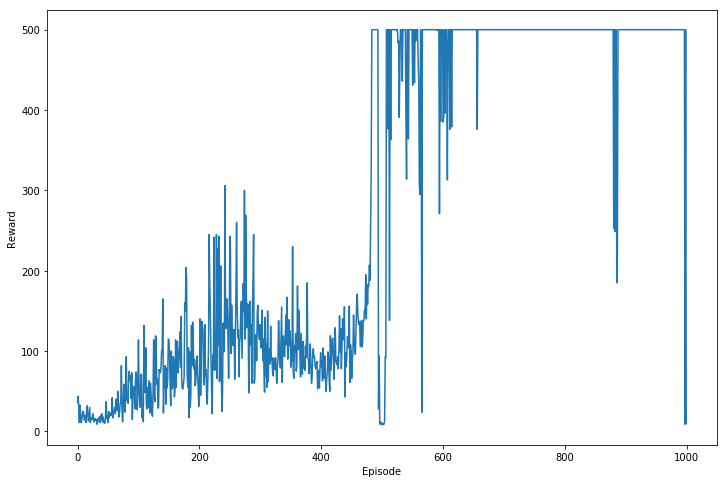

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

# Cvičení (a druhý domácí úkol)

Vyberte si z OpenAI gym některý z problémů se spojitými akcemi a zkuste ho vyřešit pomocí Actor-Critic (nebo DDPG) přístupu. 